In [125]:
from keras.models import load_model
from keras import backend as K
import numpy as np

In [126]:
results_dir = '../Physics-Informed-Machine-Learning/results_BK_v2_cnstTest/'
model_name = results_dir + 'FeatureEng_Adadelta_drop0_nL2_nN10_trsize20_iter0_NoPhyInfomodel.h5' # storing the trained model

data = np.loadtxt('../Physics-Informed-Machine-Learning/data/labeled_data.dat')
x_labeled = data[:, :-4]
y_labeled = data[:, -3:-2] # dimensionless bond length and porosity measurements

In [127]:
inputs = np.hstack((x_labeled[:,0:2],x_labeled[:,-1:]))

In [128]:
# Normalize the data.
from sklearn import preprocessing

# normalize dataset with MinMaxScaler
scaler = preprocessing.MinMaxScaler(feature_range=(0.0, 1.0))
inputs = scaler.fit_transform(inputs)

In [129]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

dependencies = {'root_mean_squared_error': root_mean_squared_error}

# load the pre-trained model using non-calibrated physics-based model predictions (./data/unlabeled.dat)
model_loaded = load_model(model_name, custom_objects=dependencies)

In [157]:
def model(X):
    return model_loaded.predict(X)

[5]


In [131]:
# model.predict(inputs)

In [158]:
from __future__ import print_function
import openturns as ot

In [169]:
inputSample = inputs
outputSample = y_labeled
f = ot.DatabaseFunction(inputSample, outputSample)
# x = [1.8]*database.getInputDimension()
# print(database)

In [170]:
# f = ot.PythonFunction(inputs.shape[1], y_labeled.shape[1], model)
# f = ot.MemoizeFunction(f)
# f.setOutputDescription(["BL"])

In [171]:
# Create the input independent joint distribution
distribution = ot.Normal(3)
distribution.setDescription(['T', 'S', 'bl'])

In [172]:
# Create the correlated input distribution
corr = ot.CorrelationMatrix(3)
corr[1, 0] = 0.46
corr[2, 0] = 0.93
corr[2, 1] = 0.74

In [173]:
R = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(corr)
copula = ot.NormalCopula(R)
distribution_corr = ot.ComposedDistribution([ot.Normal()] * 3, copula)

In [174]:
# ANCOVA needs a functional decomposition of the model
enumerateFunction = ot.LinearEnumerateFunction(3)
productBasis = ot.OrthogonalProductPolynomialFactory([ot.HermiteFactory()]*3, enumerateFunction)
adaptiveStrategy = ot.FixedStrategy(productBasis, enumerateFunction.getStrataCumulatedCardinal(4))
samplingSize = 250
projectionStrategy = ot.LeastSquaresStrategy(ot.MonteCarloExperiment(samplingSize))
algo = ot.FunctionalChaosAlgorithm(f, distribution, adaptiveStrategy, projectionStrategy)
algo.run()
result = ot.FunctionalChaosResult(algo.getResult())

In [175]:
# Create the input sample taking account the correlation
size = 2000
sample = distribution_corr.getSample(size)

In [176]:
# Perform the decomposition
ancova = ot.ANCOVA(result, sample)
# Compute the ANCOVA indices (first order and uncorrelated indices are computed together)
indices = ancova.getIndices()
# Retrieve uncorrelated indices
uncorrelatedIndices = ancova.getUncorrelatedIndices()
# Retrieve correlated indices:
correlatedIndices = indices - uncorrelatedIndices

In [177]:
# Print Sobol' indices, the physical part, and the correlation part
print("ANCOVA indices ", indices)
print("ANCOVA uncorrelated indices ", uncorrelatedIndices)
print("ANCOVA correlated indices ", correlatedIndices)

ANCOVA indices  [0.276873,0.269749,0.0176706]
ANCOVA uncorrelated indices  [0.280552,0.400369,0.034137]
ANCOVA correlated indices  [-0.00367882,-0.13062,-0.0164665]


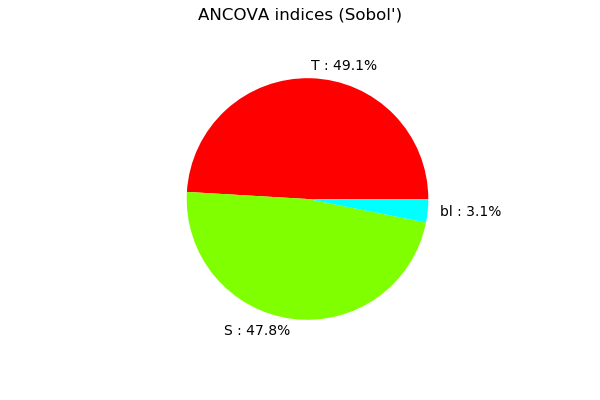

In [178]:
ot.SobolIndicesAlgorithm.DrawImportanceFactors(indices, distribution.getDescription(), 'ANCOVA indices (Sobol\')')

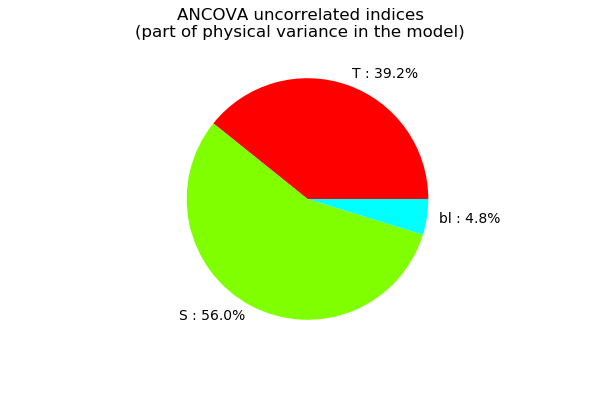

In [179]:
ot.SobolIndicesAlgorithm.DrawImportanceFactors(uncorrelatedIndices, distribution.getDescription(), 'ANCOVA uncorrelated indices\n(part of physical variance in the model)')

In [180]:
ot.SobolIndicesAlgorithm.DrawImportanceFactors(correlatedIndices, distribution.getDescription(), 'ANCOVA correlated indices\n(part of variance due to the correlation)')

TypeError: InvalidArgumentException : Expected positive values